In [ ]:
# Parameters
artificial_humans = "../../data/dev/data/model.pt"
output_file = "../../data/dev/data/manager_run.pt"
model_args = {"n_layers": 2, "hidden_size": 40}
opt_args = {"lr": 0.003}
gamma = 0.8
eps = 0.2
target_update_freq = 10
n_episode_steps = 16
n_episodes = 10000
sample_args = {"batch_size": 10, "horizon": 1000}


In [6]:
%load_ext autoreload
%autoreload 2

import torch as th
from aimanager.manager.memory import Memory
from aimanager.manager.environment import ArtificialHumanEnv
from aimanager.artificial_humans.artificial_humans import ArtificialHuman
from aimanager.manager.manager import ArtificalManager

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# from aimanager.model.neural.random import RandomArtificialHumans

device = th.device('cpu')
rec_device = th.device('cpu')
artifical_humans = ArtificialHuman.load(artificial_humans)

env = ArtificialHumanEnv(
    artifical_humans=artifical_humans, n_agents=4, n_contributions=21, n_punishments=31, episode_steps=n_episode_steps, device=device)

In [8]:
from itertools import count


manager = ArtificalManager(
    n_contributions=21, n_punishments=31, model_args=model_args, opt_args=opt_args, gamma=gamma, 
    target_update_freq=target_update_freq, device=device)

replay_mem = Memory(n_episodes=100, n_episode_steps=n_episode_steps-1, output_file=None, device=device)
recorder = Memory(n_episodes=n_episodes, n_episode_steps=n_episode_steps, output_file=output_file, device=device)


for episode in range(n_episodes):
    if (episode > 1) and (episode % 200 == 0):
        print(f'Start episode {episode}.')
        print((replay_mem.memory['rewards'].sum()/len(replay_mem)).item())

    state = env.init_episode()

    manager.init_episode(episode)
     
    current_obs = manager.encode_obs(**state)
    for step in count():
        # Get q values from controller
        q_values = manager.get_q(manager_observations=current_obs)

        # Sample a action
        selected_actions = manager.eps_greedy(q_values=q_values, eps=eps)

        state = env.punish(selected_actions)
        recorder.add(**state)

        # pass actions to environment and advance by one step
        state, rewards, done = env.step()

        if done:
            replay_mem.add(
                episode_step=step, actions=selected_actions, rewards=rewards, 
                current_obs=current_obs)
        else:
            next_obs = manager.encode_obs(**state)
            replay_mem.add(
                episode_step=step, actions=selected_actions, rewards=rewards, 
                current_obs=current_obs, next_obs=next_obs)
            current_obs = next_obs
        
        if done:
            # allow manager to update itself
            sample = replay_mem.sample(**sample_args)
            if sample is not None:
                manager.update(**sample)
            break
    recorder.add(**state)
    recorder.next_episode(episode)
    replay_mem.next_episode(episode)


Start episode 200.
844.6220092773438
Start episode 400.
907.9159545898438
Start episode 600.
915.4840087890625
Start episode 800.
898.43798828125
Start episode 1000.
924.3179931640625
Start episode 1200.
972.73193359375
Start episode 1400.
996.1919555664062
Start episode 1600.
987.1380615234375
Start episode 1800.
1123.66796875
Start episode 2000.
1144.4820556640625
Start episode 2200.
1130.798095703125
Start episode 2400.
1114.7760009765625
Start episode 2600.
1150.85205078125
Start episode 2800.
1121.1959228515625
Start episode 3000.
1122.6700439453125
Start episode 3200.
1138.093994140625
Start episode 3400.
1143.5980224609375
Start episode 3600.
1159.2099609375
Start episode 3800.
1156.9639892578125
Start episode 4000.
1173.10791015625
Start episode 4200.
1147.9539794921875
Start episode 4400.
1163.0780029296875
Start episode 4600.
1169.7860107421875
Start episode 4800.
1132.9599609375
Start episode 5000.
1194.1259765625
Start episode 5200.
1217.672119140625
Start episode 5400.
124

## Investigate policy

<AxesSubplot:>

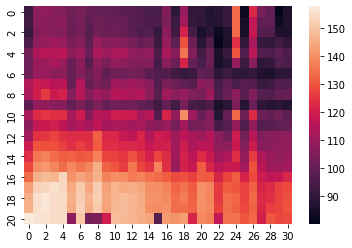

In [12]:
import seaborn as sns

data = {
    'contributions': th.arange(0,21),
    'episode_step': th.tensor(0),
}

# obs = manager.

data['punishments'] = manager.act(**data)

obs = manager.encode_obs(**data)
q = manager.get_q(manager_observations=obs)
sns.heatmap(q)


## Investigate trajectory

In [ ]:
from aimanager.utils.array_to_df import using_multiindex

def to_series(k, v):
    dims = ['episode', 'step', 'agent'][:len(v.shape)]
    sr = using_multiindex(v, dims).set_index(dims).rename(columns={"value": k})
    sr.name = k
    return sr
dfs = [to_series(k, v)
    for k, v in recorder.memory.items() if len(v.shape) <= 3
]
dfs = [df.reindex(dfs[0].index) for df in dfs]
rec_df = pd.concat(dfs, axis=1).reset_index(drop=True)

dfs = [to_series(k, v)
    for k, v in replay_mem.memory.items() if len(v.shape) <= 3
]
dfs.append(to_series('current_obs', th.argmax(replay_mem.memory['current_obs'], -1)))
dfs = [df.reindex(dfs[0].index) for df in dfs]
repm_df = pd.concat(dfs, axis=1).reset_index(drop=True)

<AxesSubplot:xlabel='punishments', ylabel='count'>

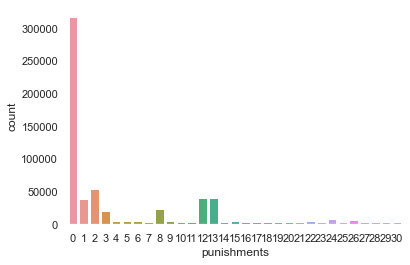

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=rec_df, x='punishments')

<AxesSubplot:xlabel='prev_punishments', ylabel='count'>

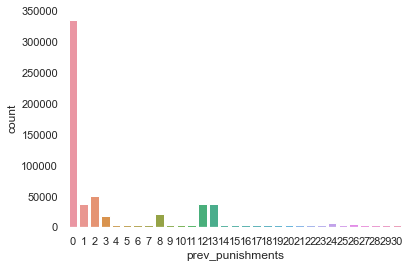

In [ ]:
sns.countplot(data=rec_df, x='prev_punishments')

<AxesSubplot:title={'center':'mean'}, xlabel='prev_contributions', ylabel='prev_punishments'>

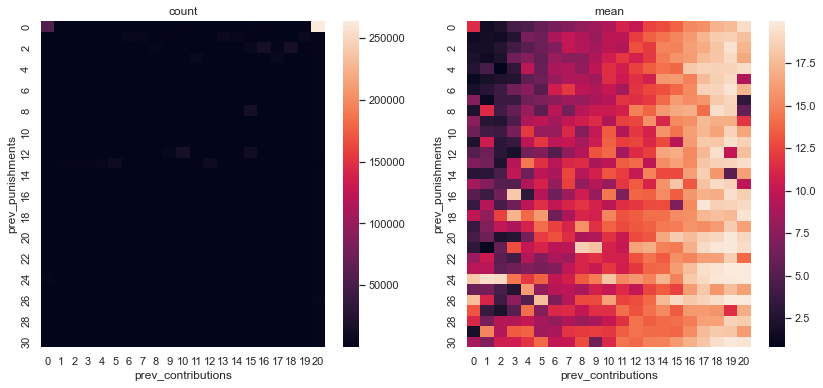

In [ ]:
df_count_pt = rec_df.pivot_table(index=['prev_punishments'], columns='prev_contributions', values='contributions', aggfunc=len)
df_mean_pt = rec_df.pivot_table(index=['prev_punishments'], columns='prev_contributions', values='contributions', aggfunc=np.mean)



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.set_title('count')
sns.heatmap(df_count_pt, ax=ax1)
ax2.set_title('mean')
sns.heatmap(df_mean_pt, ax=ax2)

<AxesSubplot:title={'center':'mean'}, xlabel='actions', ylabel='current_obs'>

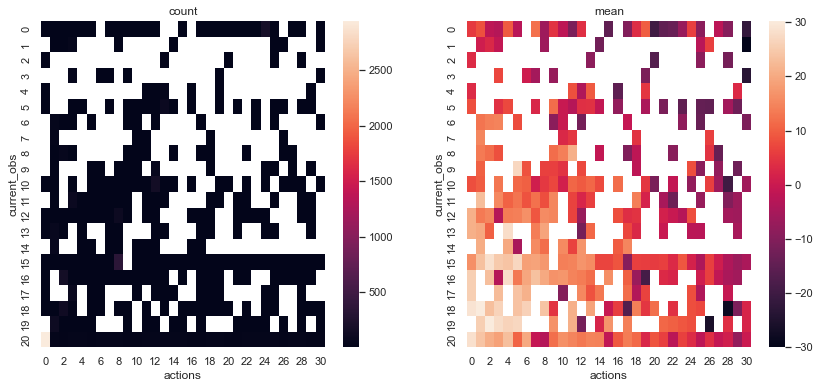

In [ ]:
df_count_pt = repm_df.pivot_table(index=['current_obs'], columns='actions', values='rewards', aggfunc=len)
df_mean_pt = repm_df.pivot_table(index=['current_obs'], columns='actions', values='rewards', aggfunc=np.mean)



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.set_title('count')
sns.heatmap(df_count_pt, ax=ax1)
ax2.set_title('mean')
sns.heatmap(df_mean_pt, ax=ax2)

## Simulate managment of artificial humans

In [ ]:

rec = {
    'value': [],
    'name': [],
    'round_number': [],
    'episode': [],
    'player_id': [],
}

for i in range(45):
    state = env.init_episode()
    done = False
    next_done = False
    rn = 0
    while not next_done:
        next_done = done
        contributions = state['contributions']
        punishments = manager.act(**state)
        if not next_done:
            env.punish(punishments)
            state, reward, done = env.step()

        common_good = contributions * 1.6 - punishments

        rec['value'].extend(contributions.tolist()+punishments.tolist()+common_good.tolist())
        rec['name'].extend(['contributions']*4 + ['punishments']*4 + ['common_good']*4)
        rec['episode'].extend([i]*12)
        rec['round_number'].extend([rn]*12)
        rec['player_id'].extend([0,1,2,3]*3)
        rn += 1


In [ ]:
df = pd.DataFrame(rec)

<AxesSubplot:xlabel='round_number', ylabel='value'>

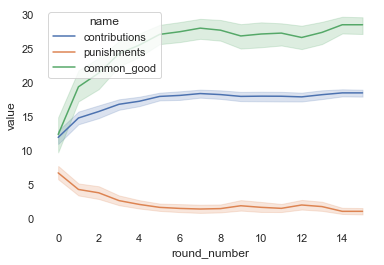

In [ ]:

sns.lineplot(data=df, x='round_number', hue='name', y='value')

In [ ]:
import os
folder = '../data/dev/data'
df.to_parquet(os.path.join(folder, 'artificial_human_rl_simulation.parquet'))